# Scraping steam reviews

### Import libraries

In [4]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Requests
import json
import glob
import requests

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from top2vec import Top2Vec

# Visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Utilities
import re
from tqdm import tqdm

In [5]:
nltk.download([
    "names",
    "stopwords",
    "averaged_perceptron_tagger",
    "punkt"
])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\lucam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\names.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

### Get response

In [6]:
def get_reviews(app_id, params={'json':1}):
    url = 'https://store.steampowered.com/appreviews/' # docu: https://partner.steamgames.com/doc/store/getreviews
    response = requests.get(url=url+app_id, params=params, headers={'User-Agent': 'Mozilla/5.0'})
    return response.json()

def get_n_reviews(app_id, n, language='english', review_type='all'):
    reviews = []
    review_count = 0
    iter_review_count = 0
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 365,
            'review_type' : review_type,
            'purchase_type' : 'all',
            'num_per_page': 100
            }

    while review_count < n:
        params['num_per_page'] = min(params['num_per_page'], (n - review_count))
        response = get_reviews(app_id, params)
        reviews += response['reviews']
        num_reviews = response['query_summary']['num_reviews']
        params['cursor'] = response['cursor'].encode()
        review_count += num_reviews

        if iter_review_count == review_count: break

        iter_review_count = review_count

        if num_reviews < 100: break

    print(f"Returning {len(reviews)} reviews")
    return reviews

In [7]:
reviews_json = get_n_reviews('1716740', 15_000, review_type='negative')

# 1716740 : Starfield
# 292030 : The Witcher 3 - The Wild Hunt
# 1084640 : Chicken Police

Returning 6051 reviews


In [8]:
df_reviews = pd.DataFrame(reviews_json)
df_reviews = df_reviews.drop_duplicates('recommendationid')
docs = df_reviews.review.tolist()

# Lemmatize / stopwords

In [9]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADVERB"]):
    nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = [x.lemma_ for x in doc if x.pos_ in allowed_postags]
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out


In [10]:
def remove_url(texts):
  return [re.sub("https?\S+","", text) for text in texts]

In [11]:
def remove_punctuation(texts):
  return [re.sub("[^\w\s\']", "", text) for text in texts];

In [12]:
def remove_stopwords(texts):
  stop_words = stopwords.words("english")
  new_texts = []
  for text in texts:
    text_split = text.split()
    text_without_stopwords = ' '.join([word for word in text_split if word.lower() not in stop_words])
    new_texts.append(text_without_stopwords)
  return new_texts

In [15]:
docs_lem = lemmatization(docs)
docs_lem = remove_url(docs_lem)
docs_lem = remove_punctuation(docs_lem)
docs_lem = remove_stopwords(docs_lem)

In [16]:
for doc in docs_lem[:5]:
  print(f">>> {doc[:200]}...")

>>> rate ok mediocre game moment feel regression quality previous title mile wide inch deep quest feel hearted cut short time bland Bethesda create lore game choose boring time start adventure colony war ...
>>> play small feel small previous title ironic consider scale universe attempt create first time less hour feel game new show reward wander far corner map prospect new experience level world soul interes...
>>> game hit miss sure think part time enjoy part find bored uninterested graphic okay gameplay feel old find skip conversation exploration portion game lack space game seem travel space use map menu jump...
>>> debate get decide want write mod fun derive game game like get new play bad game planet disconencte least world contiguous coherency game wild west planet cyberpunk planet find bunch desolate moon rin...
>>> decide put good hour write review final straw realise power unlock system game similar unlock dragonborn power implement believe see actual gameplay loop talk npc f

# Top2Vec

In [17]:
# train model
model = Top2Vec(
    documents = docs_lem,
    min_count = 30, # less for smaller corpus
    speed = 'deep-learn',
    embedding_model="doc2vec"
    #ngram_vocab = True
)

# great results: min_count 30, speed deep-learn, embedding_model doc2vec

2023-10-09 22:11:16,588 - top2vec - INFO - Pre-processing documents for training
2023-10-09 22:11:17,828 - top2vec - INFO - Creating joint document/word embedding
2023-10-09 22:16:45,512 - top2vec - INFO - Creating lower dimension embedding of documents
2023-10-09 22:17:25,917 - top2vec - INFO - Finding dense areas of documents
2023-10-09 22:17:26,295 - top2vec - INFO - Finding topics


In [18]:
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[268 207 139 136 134 129 126 118 113 112 107  95  94  94  92  90  89  89
  87  87  85  85  82  81  79  78  76  74  72  72  72  71  70  70  70  69
  67  67  67  67  66  65  65  63  62  62  62  62  61  60  60  59  59  59
  58  58  56  56  55  55  55  55  54  54  53  53  53  52  52  51  50  49
  46  45  44  43  42  41  38  38]


In [19]:
topic_words, word_scores, topic_nums = model.get_topics(min(50,len(topic_sizes)))

In [23]:
# create a list of all words, scores, and topic numbers -> for use in dataframe
topic_list = []
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    for word, score in zip(words, scores):
        topic_list.append((num, word, score))

In [24]:
df = pd.DataFrame(topic_list, columns=['num','word','score'])
df.head(10)

,num,word,score
0,0,audio,0.580894
1,0,freeze,0.566886
2,0,unplayable,0.555032
3,0,stuttering,0.449927
4,0,lag,0.422997
5,0,stutter,0.386285
6,0,sync,0.369331
7,0,driver,0.368890
8,0,pc,0.358803
9,0,ram,0.355645


In [27]:
fig = make_subplots(rows=3, cols=3,  vertical_spacing = 0.1, horizontal_spacing = 0.15)

counter = 0
number_of_words = 10

for i in range(3):
  for j in range(3):
    df_n = df.query("num == @counter").head(number_of_words).sort_values(by='score',ascending=True)
    cluster_name = f"{counter}: {' - '.join(df_n.iloc[-3:].word)}"
    fig.add_trace(go.Bar(x=df_n.iloc[:number_of_words].score, y=df_n.iloc[:number_of_words].word, orientation='h', name=cluster_name), row=i+1, col=j+1)
    counter += 1

fig.update_layout(height=900, width=1200, title_text="Topic clusters")
fig.show()


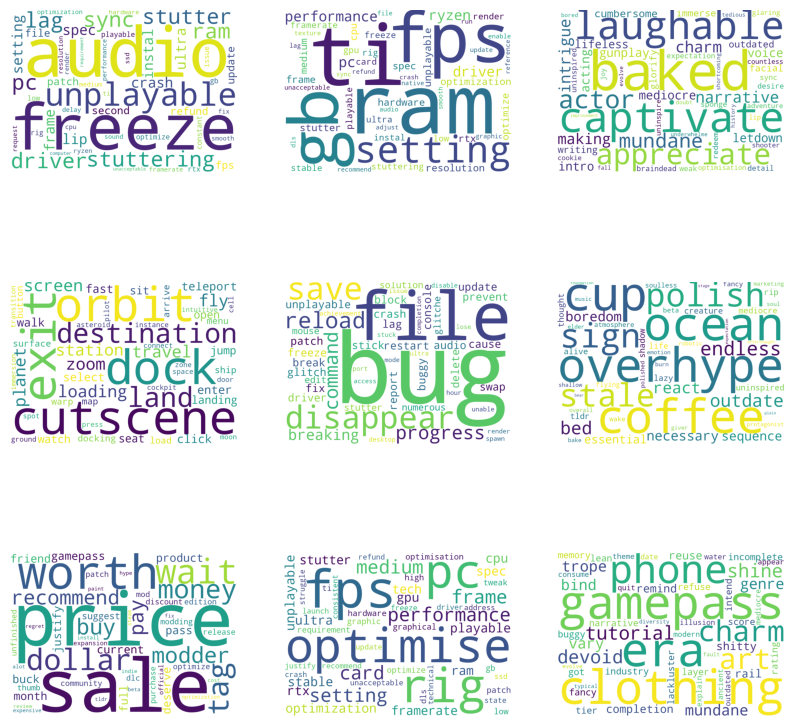

In [28]:
grid = (3,3)
fig, ax = plt.subplots(nrows=grid[0],ncols=grid[1],figsize=(10,10))

counter = 0

for i in range(grid[0]):
  for j in range(grid[1]):
    cluster_words = df.query("num == @counter").word
    counter += 1
    wordcloud = WordCloud (background_color = 'white',
                        width = 1080,
                        height = 770
                            ).generate(' '.join(cluster_words))
    ax[i,j].imshow(wordcloud) # image show
    ax[i,j].axis('off')

In [29]:
# Print top 10 docs for cluster 7
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num = 7, num_docs=10)
for doc, score, id in zip(documents, document_scores, document_ids):
    #print(f"ID: {id} - Score: {score}")
    print(f">>> {doc}")

>>> optimise release run bad
>>> seem optimise
>>> need optimise
>>> optimise pc moment recommend wait play
>>> get decent rig run 65fps boring refunded
>>> optimise card
>>> refund finish optimise
>>> optimization bad rig shred recommend spec
>>> optimise get fps super medium setting
>>> goyslop ready


In [30]:
# Print top 5 words for every cluster
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(f"{num+1}: {words[:5]}")

1: ['audio' 'freeze' 'unplayable' 'stuttering' 'lag']
2: ['ram' 'ti' 'fps' 'gb' 'setting']
3: ['baked' 'captivate' 'laughable' 'appreciate' 'actor']
4: ['cutscene' 'orbit' 'dock' 'exit' 'destination']
5: ['bug' 'file' 'disappear' 'save' 'reload']
6: ['overhype' 'cup' 'coffee' 'ocean' 'sign']
7: ['price' 'sale' 'worth' 'wait' 'dollar']
8: ['fps' 'optimise' 'rig' 'pc' 'performance']
9: ['gamepass' 'era' 'clothing' 'phone' 'charm']
10: ['man' 'sky' 'skyrim' 'marker' 'fallout']
11: ['get' 'fun' 'buy' 'think' 'wait']
12: ['disappointed' 'funny' 'trash' 'refund' 'horrible']
13: ['captivate' 'narrative' 'lack' 'shortcoming' 'promise']
14: ['meh' 'key' 'gate' 'meaningless' 'hollow']
15: ['garbage' 'money' 'waste' 'refund' 'hrs']
16: ['brightness' 'slider' 'potato' 'file' 'resolution']
17: ['simulator' 'screen' 'loading' 'load' 'fly']
18: ['lvl' 'outer' 'suck' 'battle' 'decorate']
19: ['link' 'traveling' 'storage' 'container' 'pad']
20: ['fi' 'sci' 'protagonist' 'formula' 'fall']
21: ['bear' 'w

In [31]:
# Custom search to find some reviews where keyword is mentioned
def search_review_for_keyword(keyword='', number_of_examples=10):
  df_reviews_match = df_reviews.query("review.str.contains(@keyword)").iloc[:number_of_examples].review
  for review in df_reviews_match:
    sentences = [sentence for sentence in re.split(pattern = "[.,!?\n]",string=review) if sentence.find(keyword) != -1]
    joined = ' | '.join(sentences)
    highlighted = keyword.upper().join(joined.split(keyword))
    print(f">>> {highlighted}")

In [32]:
search_review_for_keyword("loading screen",5)

>>>  I use the map menu to jump light-years away in a single LOADING SCREEN |  Entire galaxies are bypassed via LOADING SCREENs and much of the game-play feels at least a decade old
>>> It's a fast travel and LOADING SCREEN simulator | 40% of my playtime is me navigating through clunky menus or watching LOADING SCREENs and I lost 60h of playtime due to several game breaking bugs
>>>  divide everything within with LOADING SCREENs |  you still need LOADING SCREEN for every shop |  you have 15 LOADING SCREENs coming | Exit planet LOADING SCREEN | Enter orbit LOADING SCREEN | Land planet LOADING SCREEN | Exit ship LOADING SCREEN | Enter shop LOADING SCREEN | Exit shop LOADING SCREEN | Enter ship LOADING SCREEN | Exit planet LOADING SCREEN | Enter orbit LOADING SCREEN | Land planet LOADING SCREEN | Exit ship LOADING SCREEN | Enter building LOADING SCREEN | Exit building LOADING SCREEN | Enter ship LOADING SCREEN | Exit planet LOADING SCREEN | Enter orbit LOADING SCREEN | Land planet LOADING